# Using Earth Access to Build and image

The goal is to use Earth Access to 

- load the rasters that cover Madison
- process them
- merge (or mosaic) them into one image

This is a reworking of 
[92-bulk-download](https://github.com/earthlab-education/fundamentals-04-redlining-byandell/blob/main/notebooks/redlining-92-bulk-download.ipynb).

In [1]:
city = "Madison"

In [2]:
pip install ~/Documents/GitHub/landmapy

Processing /Users/brianyandell/Documents/GitHub/landmapy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for landmapy: filename=landmapy-0.2-py3-none-any.whl size=38018 sha256=6a032571a9fcbc2a53886a369c488355b77b2b5ca081cc2929480ce4ec9d2220
  Stored in directory: /private/var/folders/tt/cyd1sy9s18l1fgc_0ty8l91w0000gn/T/pip-ephem-wheel-cache-avaqnuxb/wheels/d4/8b/49/f05ffe83c93ff1cc194a4161d132e5ba0632f5ae288edbcd13
Successfully built landmapy
  Attempting uninstall: landmapy
    Found existing installation: landmapy 0.2
    Uninstalling landmapy-0.2:
      Successfully uninstalled landmapy-0.2
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Define and create the project data directory
import os # Interoperable file paths
import pathlib # Find the home folder

data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'redlining'
)
os.makedirs(data_dir, exist_ok=True)
data_dir

'/Users/brianyandell/earth-analytics/data/redlining'

## Site Map

In [4]:
import landmapy
from landmapy.redline import redline_gdf, plot_redline

/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/brianyandell/earth-analytics/data/redlining/redlining/redlining.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


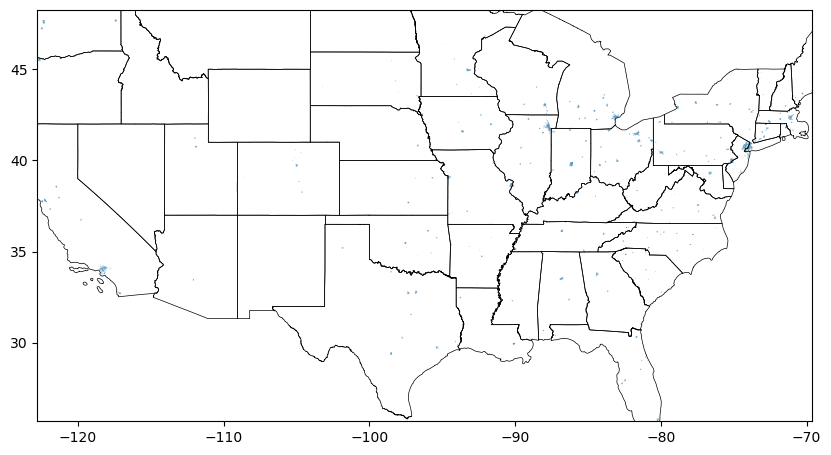

In [5]:
redlining_gdf = redline_gdf(data_dir)
plot_redline(redlining_gdf)

<Axes: >

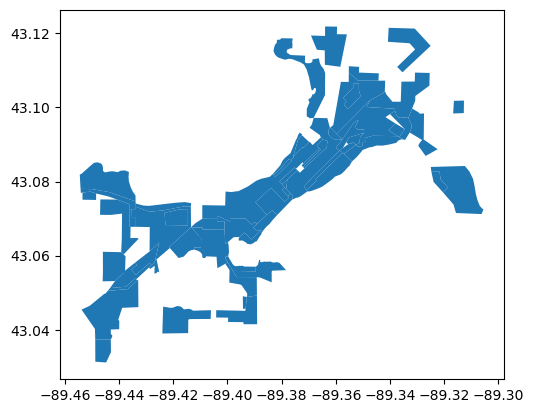

In [6]:
city_redlining_gdf = redlining_gdf[redlining_gdf.city == city]
city_redlining_gdf.plot()

## Select EarthAccess Images

The goal is to use Earth Access to

1. load the rasters that cover selected `city`,
2. process them, and 
3. merge (or mosaic) them into one image

Search for the `city` data and create file connections `city_files`.

In [7]:
%store -r city_files
try:
    city_files
except NameError:
    import earthaccess # Access NASA data from the cloud
    
    # `city_files` does not yet exist
    earthaccess.login(strategy="interactive", persist=True)
    # Search earthaccess
    city_results = earthaccess.search_data(
        short_name="HLSL30",
        bounding_box=tuple(city_redlining_gdf.total_bounds),
        temporal=("2023-07-12", "2023-07-13"),
        count=1)
    city_files = earthaccess.open(city_results)
    %store city_files
    print("city_files created and stored")
else:
    print("city_files already exists")


city_files already exists


## Process EarthAccess Images

In [8]:
from landmapy.process import process_image, process_metadata, process_cloud_mask, process_bands

In [9]:
raster_df = process_metadata(city_files)

# Check the results
raster_df.head()

,tile_id,date,band_id,file
0,T16TCN,2023194,SAA,"<File-like object HTTPFileSystem, https://data..."
1,T16TCN,2023194,B11,"<File-like object HTTPFileSystem, https://data..."
2,T16TCN,2023194,B01,"<File-like object HTTPFileSystem, https://data..."
3,T16TCN,2023194,VZA,"<File-like object HTTPFileSystem, https://data..."
4,T16TCN,2023194,B09,"<File-like object HTTPFileSystem, https://data..."


In [10]:
%store -r city_das
try:
    city_das
except NameError:
    city_das = process_bands(city_redlining_gdf, raster_df)
    %store city_das
    print("city_das created and stored")
else:
    print("city_das already stored")

city_das already stored


There are large parts of the area that are missing. I could not find another date with better imaging,
probably because `city` Madison is so small on image, and it has five lakes.
A couple things I would like to be able to do:

- Show plot from `raster_df` to show something like image seen on NASA HLS30.
- Outline the lakes.
- Convert to CRS `EPSG:4326`

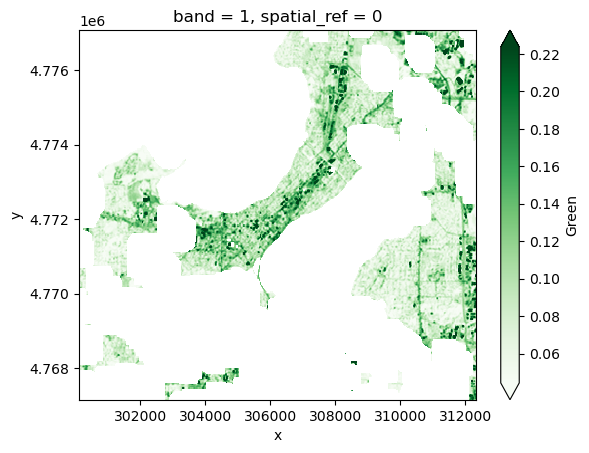

In [11]:
city_das['green'].rio.write_crs("EPSG:4326").plot(cmap='Greens', robust=True)

## NDVI

NDVI compares the amount of NIR reflectance to the amount of Red reflectance, thus accounting for many of the species differences and isolating the health of the plant.


In [12]:
from landmapy.plot import plot_index, plot_gdf_da

In [13]:
city_ndvi_da = (
    (city_das['nir'] - city_das['red']) / (city_das['nir'] + city_das['red'])
)

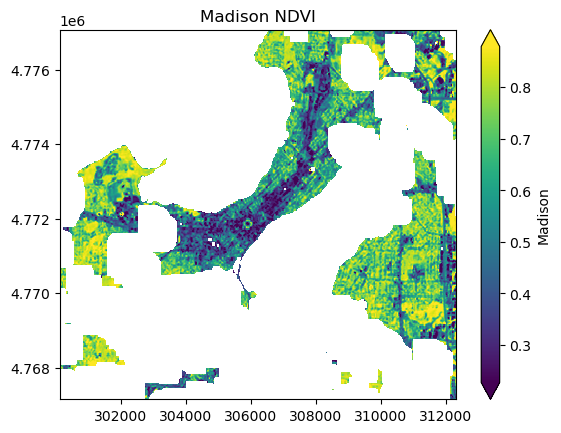

In [14]:
plot_index(city_ndvi_da, city)

Overlay redlining grades on NDVI map.

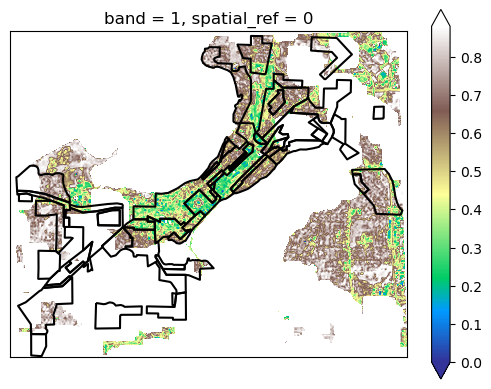

In [15]:
plot_gdf_da(city_redlining_gdf, city_ndvi_da)

## Zonal Statistics

In [16]:
from landmapy.redline import redline_mask, redline_index_gdf
from landmapy.hvplot import hvplot_index_grade

In [17]:
redlining_mask = redline_mask(city_redlining_gdf, city_ndvi_da)

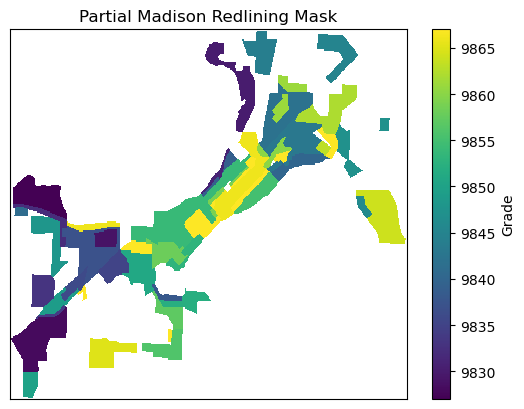

In [18]:
# Plot the redlining mask 
redlining_mask.plot(cbar_kwargs={"label": "Grade"})

import matplotlib.pyplot as plt # Make subplots

plt.gca().set(title = 'Partial ' + city + ' Redlining Mask', 
    xlabel='', ylabel='', xticks=[], yticks=[])
plt.show()

In [19]:
from xrspatial import zonal_stats # Calculate zonal statistics

# Calculate NDVI stats for each redlining zone
ndvi_stats = zonal_stats(redlining_mask, city_ndvi_da)

# Call denver_ndvi_states to see the table
ndvi_stats.head()

/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


,zone,mean,max,min,sum,std,var,count
0,9827.0,0.728887,0.969571,0.315103,500.016632,0.096498,0.009312,686.0
1,9828.0,0.772770,0.919229,0.483455,327.654419,0.073992,0.005475,424.0
2,9829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9830.0,0.703321,0.903301,0.312640,789.829224,0.094096,0.008854,1123.0
4,9831.0,0.612807,0.772392,0.308735,71.698364,0.090015,0.008103,117.0


In [20]:
redlining_ndvi_gdf = redline_index_gdf(redlining_gdf, ndvi_stats)

In [21]:
ndvi_hv, grade_hv = hvplot_index_grade(redlining_ndvi_gdf, city)
(ndvi_hv + grade_hv)

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (mean)
   .Polygons.II :Polygons   [Longitude,Latitude]   (grade)

## Fitting Tree Model

Somehow I have to go from city_ndvi_da to redlining_ndvi_gdf.

In [22]:
from landmapy.explore import index_tree
from landmapy.hvplot import hvplot_index_pred

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score

In [23]:
tree_classifier = index_tree(redlining_ndvi_gdf)

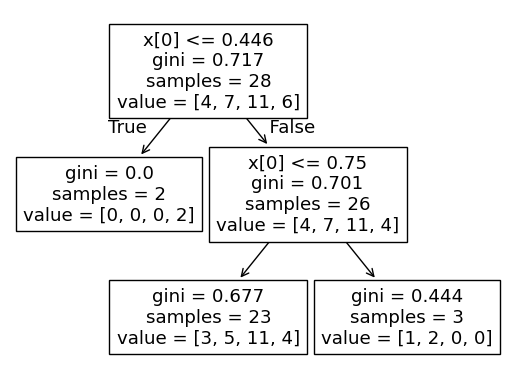

In [24]:
tree_classifier = index_tree(redlining_ndvi_gdf)

# Visualize tree
plot_tree(tree_classifier)
plt.show()

In [25]:
pred_hv = hvplot_index_pred(redlining_ndvi_gdf, tree_classifier, city)
pred_hv

:Polygons   [Longitude,Latitude]   (error)

In [26]:
# Plot NDVI, predicted and redlining grade in linked subplots
madison_hv = (ndvi_hv + pred_hv + grade_hv)

# Save the linked plots as a file to put on the web
import holoviews as hv
hv.save(madison_hv, 'madison.html')

madison_hv

:Layout
   .Polygons.I   :Polygons   [Longitude,Latitude]   (mean)
   .Polygons.II  :Polygons   [Longitude,Latitude]   (error)
   .Polygons.III :Polygons   [Longitude,Latitude]   (grade)

## Evaluate the Model

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score

In [28]:
# Evaluate the model with cross-validation
cross_val_score(
    DecisionTreeClassifier(max_depth=2),
    redlining_ndvi_gdf[['mean']],
    redlining_ndvi_gdf.grade_codes,
    cv=3
)

array([0.2       , 0.11111111, 0.11111111])

In [29]:
# Try another model - changing the hyperparameters
# Evaluate the model with cross-validation
cross_val_score(
    DecisionTreeClassifier(max_depth=4),
    redlining_ndvi_gdf[['mean']],
    redlining_ndvi_gdf.grade_codes,
    cv=3
)

array([0.3       , 0.11111111, 0.11111111])